# Surf park de Canéjan : simulation de l'approvisionement des bassins en eau

### Objectifs

Ce document vise à établir les fondations du modèle d'approvisionement en eaux des bassis du surf park de Canéjan.

### Hypothèses

- Les deux bassins sont communicant, sans limite de flux.

## Imports

In [1]:

import os
import pandas as pd
import networkx as nx
import numpy as np

from plotnine import *

from pywr.model import Model
from pywr.notebook import draw_graph

from naseb.model import model_pet_visual_crossing

## Collection de données

In [2]:
meteo_journaliere = pd.read_csv(
        './data/canéjan interpolé 1992-01-01 to 2022-12-31.csv')
meteo_decadaire = pd.read_csv('./data/weather.csv')

## Vérification des données journalières

L'objectif de cet section est de vérifier:
- la cohérence des données journalières de précipitation avec les données decadaires (10j)
- valider le modèle d'évapotranspiration potentielle

In [3]:
meteo_journaliere = model_pet_visual_crossing(meteo_journaliere)
meteo_journaliere.columns

                  datetime       tempmax       tempmin          temp  \
count                11323  11323.000000  11323.000000  11323.000000   
mean   2007-07-02 00:00:00     18.667208      9.599717     13.933383   
min    1992-01-01 00:00:00     -3.200000     -8.900000     -5.700000   
25%    1999-10-01 12:00:00     13.100000      5.500000      9.500000   
50%    2007-07-02 00:00:00     18.200000      9.900000     13.800000   
75%    2015-04-01 12:00:00     24.000000     14.100000     18.800000   
max    2022-12-31 00:00:00     40.300000     24.900000     31.700000   
std                    NaN      7.221889      5.793402      6.247120   

       feelslikemax  feelslikemin     feelslike           dew      humidity  \
count  11322.000000  11322.000000  11322.000000  11322.000000  11323.000000   
mean      18.466216      8.591388     13.380595      9.244285     76.309732   
min       -7.800000    -14.400000    -10.900000    -12.600000     30.200000   
25%       13.100000      3.500000  

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations',
       'hours_of_daylight', 'dayofyear', 'pet_penman', 'pet_kimberly_penman',
       'pet_corrected'],
      dtype='object')

In [4]:
meteo_journaliere['hours_of_daylight'].describe()

count    11323.000000
mean        12.225134
std          2.328361
min          8.791944
25%          9.975833
50%         12.254722
75%         14.480694
max         15.586111
Name: hours_of_daylight, dtype: float64

In [5]:
def decade(day):
    if day <11:
        return 1
    elif day <21:
        return 2
    else:
        return 3

meteo_journaliere['dayofmonth'] = meteo_journaliere["datetime"].dt.day
meteo_journaliere['month'] = meteo_journaliere["datetime"].dt.month
meteo_journaliere['year'] = meteo_journaliere["datetime"].dt.year
meteo_journaliere['decade'] = meteo_journaliere["dayofmonth"].apply(decade)
meteo_journaliere['pet_corrected'] = meteo_journaliere['pet_penman']/2
meteo_j_agg_decadaire = meteo_journaliere.groupby(['month', 'decade', 'year'])[['precip', 'pet_corrected', 'pet_penman', 'pet_kimberly_penman']].sum()
meteo_j_agg_decadaire

precip  pet_corrected  pet_penman  pet_kimberly_penman
month decade year                                                        
1     1      1992  24.621       8.492526   16.985052            16.985052
             1993   0.021       7.601722   15.203445            15.203445
             1994  47.322       9.329854   18.659707            18.659707
             1995  36.619       7.440299   14.880599            14.880599
             1996  13.413       9.618970   19.237939            19.237939
...                   ...            ...         ...                  ...
12    3      2018  15.920       7.209806   14.419611            14.419611
             2019  21.551      11.300545   22.601090            22.601090
             2020  73.197       8.723562   17.447125            17.447125
             2021  37.718       9.334075   18.668151            18.668151
             2022  33.905      11.055344   22.110689            22.110689

[1116 rows x 4 columns]

In [6]:
meteo_journaliere.isna().apply(sum, axis=0)

name                       0
datetime                   0
tempmax                    0
tempmin                    0
temp                       0
feelslikemax               1
feelslikemin               1
feelslike                  1
dew                        1
humidity                   0
precip                     0
precipprob                 1
precipcover                0
preciptype              4254
snow                   10967
snowdepth              10680
windgust                4750
windspeed                  0
winddir                    1
sealevelpressure           0
cloudcover                30
visibility                 1
solarradiation             0
solarenergy                0
uvindex                 6575
severerisk             10967
sunrise                    0
sunset                     0
moonphase                  0
conditions                 1
description                1
icon                       1
stations                   1
hours_of_daylight          0
dayofyear     

In [7]:
meteo_decadaire['DATE'] = pd.to_datetime(meteo_decadaire['DATE'])

meteo_decadaire['dayofmonth'] = meteo_decadaire["DATE"].dt.day
meteo_decadaire['month'] = meteo_decadaire["DATE"].dt.month
meteo_decadaire['year'] = meteo_decadaire["DATE"].dt.year

In [8]:
meteo_decadaire_merged = meteo_decadaire.merge(meteo_j_agg_decadaire, right_index=True, left_on=['month', 'DECADE','year'])
meteo_decadaire_merged

,DATE,DECADE,RR,FFM,ETP,dayofmonth,month,year,precip,pet_corrected,pet_penman,pet_kimberly_penman
0,1992-01-01,1,24.2,3.4,4.2,1,1,1992,24.621,8.492526,16.985052,16.985052
1,1992-01-11,2,0.0,2.2,2.3,11,1,1992,0.028,6.526745,13.053491,13.053491
2,1992-01-21,3,1.0,2.8,6.3,21,1,1992,1.020,10.120300,20.240601,20.240601
3,1992-02-01,1,1.8,2.1,6.6,1,2,1992,2.147,10.660711,21.321423,21.321423
4,1992-02-11,2,14.2,3.4,13.2,11,2,1992,16.000,17.658693,35.317386,35.317386
...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2022-11-11,2,52.9,3.2,7.3,11,11,2022,45.982,11.883760,23.767519,23.767519
1112,2022-11-21,3,74.7,3.2,6.4,21,11,2022,74.143,8.192020,16.384041,16.384041
1113,2022-12-01,1,3.8,2.8,4.5,1,12,2022,2.388,7.591992,15.183984,15.183984
1114,2022-12-11,2,18.7,3.6,4.1,11,12,2022,18.336,7.930121,15.860242,15.860242


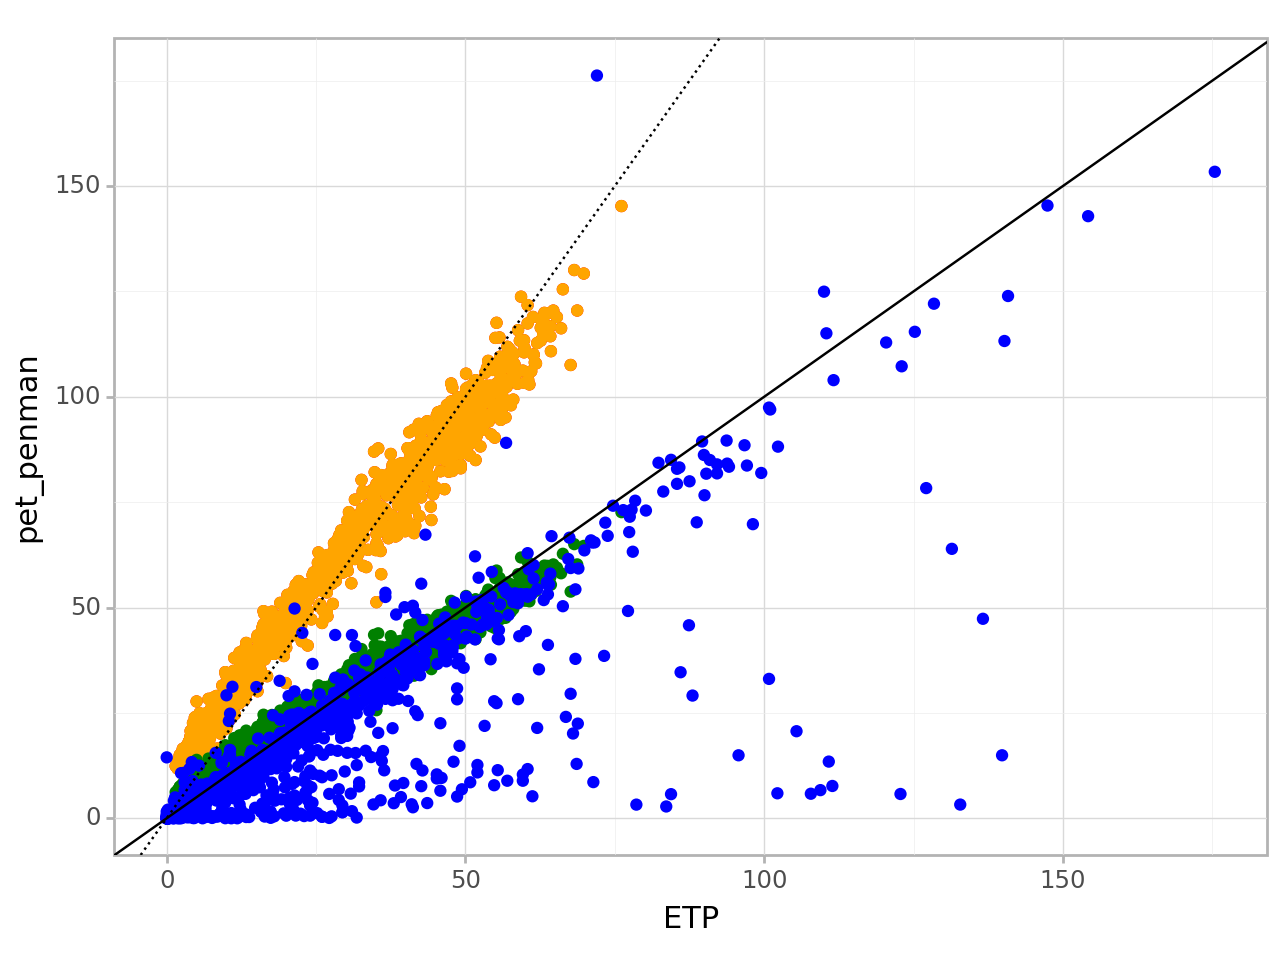

<Figure Size: (640 x 480)>

In [9]:
(
    ggplot(meteo_decadaire_merged)
    + geom_point(aes("ETP", 'pet_penman'), colour="red")
    + geom_point(aes("ETP", 'pet_kimberly_penman'), colour="orange")
    + geom_point(aes("ETP", 'pet_corrected'), colour="green")
    + geom_point(aes("RR", 'precip'), colour="blue")
    + geom_abline()
    + geom_abline(slope=2, linetype="dotted")
    + theme_light()
)

## Graph visualisation

In [10]:

m = Model.load("./models/proto_example.json")

/tmp/ipykernel_6817/1609855722.py:1: ModelDocumentWarning: Missing "minimum_version" item in metadata.


In [11]:
draw_graph(m, labels=True, attributes=True)

<IPython.core.display.Javascript object>

In [12]:
stats = m.run()
df = m.to_dataframe()
df

Recorder,rain_reservoir,tampon,bassin_overflow,rainwater_flow,pet_flow,bassin_volume
,0,0,0,0,0,0
1992-01-01,0.0,0.0,0.0,0.133465,11.811903,19988.416398
1992-01-02,0.0,0.0,0.0,0.000000,12.381816,19976.034582
1992-01-03,0.0,0.0,0.0,0.133465,9.041858,19967.221025
1992-01-04,0.0,0.0,0.0,0.000000,9.032192,19958.188833
1992-01-05,0.0,0.0,0.0,0.000000,13.790734,19944.398099
...,...,...,...,...,...,...
2022-12-26,0.0,0.0,0.0,33.423399,9.450147,17197.541538
2022-12-27,0.0,0.0,0.0,1.334648,14.101480,17185.723067
2022-12-28,0.0,0.0,0.0,0.190664,28.766863,17157.282348


In [13]:
df=df.droplevel(1, axis=1)

In [14]:
df.reset_index(drop=False, inplace=True)
df.to_csv('./sim/simulation_city_water_daily.csv')
df

Recorder,index,rain_reservoir,tampon,bassin_overflow,rainwater_flow,pet_flow,bassin_volume
0,1992-01-01,0.0,0.0,0.0,0.133465,11.811903,19988.416398
1,1992-01-02,0.0,0.0,0.0,0.000000,12.381816,19976.034582
2,1992-01-03,0.0,0.0,0.0,0.133465,9.041858,19967.221025
3,1992-01-04,0.0,0.0,0.0,0.000000,9.032192,19958.188833
4,1992-01-05,0.0,0.0,0.0,0.000000,13.790734,19944.398099
...,...,...,...,...,...,...,...
11317,2022-12-26,0.0,0.0,0.0,33.423399,9.450147,17197.541538
11318,2022-12-27,0.0,0.0,0.0,1.334648,14.101480,17185.723067
11319,2022-12-28,0.0,0.0,0.0,0.190664,28.766863,17157.282348
11320,2022-12-29,0.0,0.0,0.0,492.885506,7.473011,17992.924191


In [15]:
df=df.sort_values('bassin_volume', ascending=False).reset_index(drop=False)
df['x'] = range(len(df))

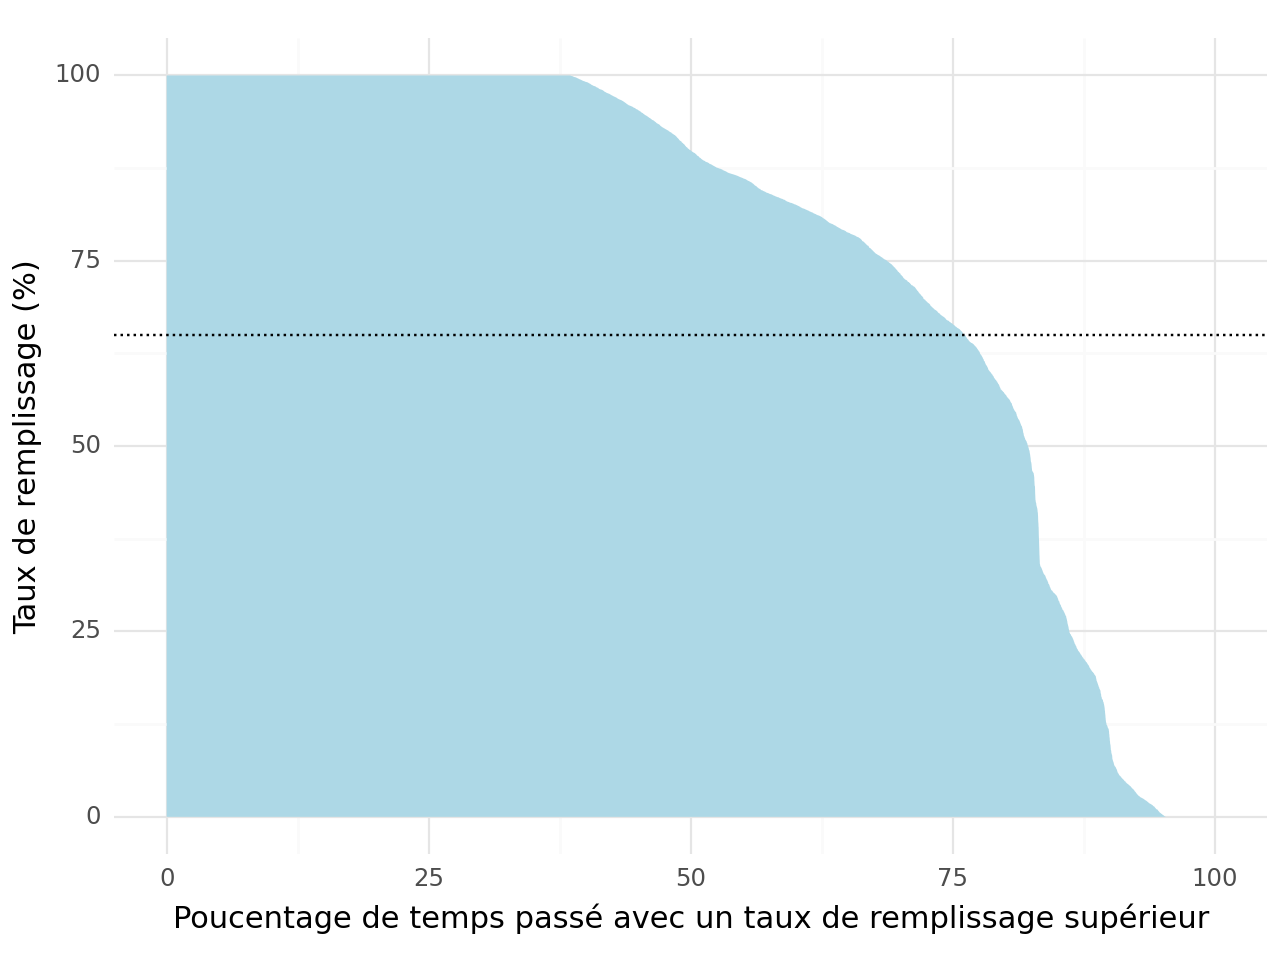

<Figure Size: (640 x 480)>

In [16]:
volume_bassin2 = 13000
(
    ggplot(df)
    + geom_ribbon(aes("x/len(x)*100", ymin=0, ymax="bassin_volume/20000*100"), fill="lightblue")
    + theme_minimal()
    + geom_abline(intercept=volume_bassin2/20000*100, slope=0, linetype="dotted")
    + labs(y="Taux de remplissage (%)", x="Poucentage de temps passé avec un taux de remplissage supérieur")
)

In [17]:
monthly_prec = pd.read_csv('./data/monthly_prec.csv')
monthly_pet = pd.read_csv('./data/mean_pet_monthly.csv')
monthly_pet

,month,pet
0,Jan,229
1,Fev,441
2,Mar,912
3,Avr,1334
4,Mai,1400
5,Juin,2077
6,Juillet,2192
7,Aout,1902
8,Sept,1288
9,Oct,721


In [18]:
monthly_prec_long = monthly_prec.melt(id_vars="year")
monthly_prec_long = monthly_prec_long.merge(monthly_pet, left_on='variable', right_on='month').drop(columns='variable')
monthly_prec_long.to_csv('./data/monthly_data.csv')
monthly_prec_long

,year,value,month,pet
0,2022,39.6,Jan,229
1,2021,125.4,Jan,229
2,2020,67.3,Jan,229
3,2019,73.1,Jan,229
4,2018,121.8,Jan,229
...,...,...,...,...
367,1996,59.0,Dec,189
368,1995,233.2,Dec,189
369,1994,103.8,Dec,189
370,1993,230.0,Dec,189


In [33]:
import datetime
import pendulum

monthly_avg_prec_long = monthly_prec_long.drop(columns="year").groupby('month').mean().reset_index()
print(set(monthly_avg_prec_long['month']))
months = ["Jan", "Fev", "Mar", "Avr", "Mai", "Juin", 
          "Juillet", "Aout", "Sept", "Oct", "Nov", "Dec"]
monthly_avg_prec_long['month'] = pd.Categorical(monthly_avg_prec_long['month'], categories=months, ordered=True)
monthly_avg_prec_long = monthly_avg_prec_long.sort_values('month').reset_index(drop=True)
starting_date = pendulum.date(1992, 1,1)
monthly_avg_prec_long['fake_index'] = [starting_date.add(days=n) for n in range(len(months)) ]
monthly_avg_prec_long['date'] = [starting_date.add(months=n) for n in range(len(months)) ]
monthly_avg_prec_long.to_csv('./data/monthly_avg_data.csv')
monthly_avg_prec_long

{'Avr', 'Juillet', 'Fev', 'Jan', 'Mai', 'Sept', 'Aout', 'Oct', 'Juin', 'Nov', 'Mar', 'Dec'}


,month,value,pet,fake_index,date
0,Jan,88.135484,229.0,1992-01-01,1992-01-01
1,Fev,67.145161,441.0,1992-01-02,1992-02-01
2,Mar,61.509677,912.0,1992-01-03,1992-03-01
3,Avr,73.787097,1334.0,1992-01-04,1992-04-01
4,Mai,70.438710,1400.0,1992-01-05,1992-05-01
5,Juin,74.577419,2077.0,1992-01-06,1992-06-01
6,Juillet,43.809677,2192.0,1992-01-07,1992-07-01
7,Aout,56.145161,1902.0,1992-01-08,1992-08-01
8,Sept,77.441935,1288.0,1992-01-09,1992-09-01
9,Oct,78.690323,721.0,1992-01-10,1992-10-01
